# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import udf
# from pyspark.sql.functions import sum as Ssum
from pyspark.sql.types import IntegerType, FloatType
# from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .config("spark.driver.bindAddress","localhost")\
    .config("spark.ui.port","4050")\
    .getOrCreate()

In [ ]:
# Check config
# spark.sparkContext.getConf().getAll()

In [ ]:
# Check session
# spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Load data
# Mini dataset
path = "../data/mini_sparkify_event_data.json"
# Full dataset
# path ="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
user_log = spark.read.json(path)

In [5]:
# check schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Describe
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [4]:
# Show 1 row
# user_log.show(n=1)
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [ ]:
# Show 5 rows
# user_log.head(5)

In [7]:
# Check num of rows, columns
user_log.count(), len(user_log.columns)

(286500, 18)

In [ ]:
# Drop NaN in userId and sessionId
# user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [ ]:
# Check how many users were actually dropped
# user_log_valid.count()

so none, really....

In [ ]:
# take a look at the users...
# user_log.select("userId").dropDuplicates().sort("userId").show()

In [ ]:
# take a look at the sessions...
# user_log.select("sessionId").dropDuplicates().sort("sessionId").show()

so some users are empty

In [8]:
user_log_valid = user_log.filter(user_log["userId"] != "")

In [9]:
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# Check available levels
# user_log.select("level").dropDuplicates().show()

In [10]:
# Check available pages
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [11]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
user_log_valid = user_log_valid.withColumn("churn", cancellation("page"))

In [ ]:
user_log_valid.head()

In [12]:
# Filter users that cancelled vs. users that stayed
users_cancelled = user_log_valid.select(["userId"]).where(user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = user_log_valid.select(["userId"]).where(user_log_valid.churn == 0).dropDuplicates().collect()

In [13]:
len(users_cancelled), len(users_staying)

(52, 225)

In [14]:
# Check what happens to the first userID leaving
user_canc_0_lifecycle = user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
    where(user_log_valid.userId == users_cancelled[0][0]).collect()

In [15]:
# The beginning...
user_canc_0_lifecycle[:10]

[Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317144000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317481000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317711000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317914000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318124000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318515000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318728000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318906000),
 Row(userId='125', firstname='Mason', page='Roll Advert', level='free', ts=1539318917000),
 Row(userId='125', firstname='Mason', page='Cancel', level='free', ts=1539318918000)]

In [16]:
# ... the end
user_canc_0_lifecycle[-10:]

[Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317481000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317711000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539317914000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318124000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318515000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318728000),
 Row(userId='125', firstname='Mason', page='NextSong', level='free', ts=1539318906000),
 Row(userId='125', firstname='Mason', page='Roll Advert', level='free', ts=1539318917000),
 Row(userId='125', firstname='Mason', page='Cancel', level='free', ts=1539318918000),
 Row(userId='125', firstname='Mason', page='Cancellation Confirmation', level='free', ts=1539318918000)]

As a variable of interest we can consider the amount of time spent with the service:

In [17]:
# How much time did he/she spend with the service:
print('Example of a user leaving the service:')
print('Date when joining: ', datetime.fromtimestamp(user_canc_0_lifecycle[0][4]/1000))
print('Date when leaving: ', datetime.fromtimestamp(user_canc_0_lifecycle[-1][4]/1000))
      
# Quantify that time in days...
print('Interval in days: ', '{:.3f}'.format((user_canc_0_lifecycle[-1][4]/1000 - user_canc_0_lifecycle[0][4]/1000)\
                                            /(3600*24)))

Example of a user leaving the service:
Date when joining:  2018-10-12 06:05:44
Date when leaving:  2018-10-12 06:35:18
Interval in days:  0.021


We can take a look at the same metric for a user that stayed with the service:

In [18]:
# First userID staying
user_stay_0_lifecycle = user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
    where(user_log_valid.userId == users_staying[0][0]).collect()

# How much time did he/she spend with the service:
print('Example of a user staying with the service:')
print('Date when joining: ', datetime.fromtimestamp(user_stay_0_lifecycle[0][4]/1000))
print('Last date recorded: ', datetime.fromtimestamp(user_stay_0_lifecycle[-1][4]/1000))
      
# Quantify that time in days...
print('Interval in days: ', '{:.3f}'.format((user_stay_0_lifecycle[-1][4]/1000 - user_stay_0_lifecycle[0][4]/1000)\
                                            /(3600*24)))

Example of a user staying with the service:
Date when joining:  2018-10-08 14:58:54
Last date recorded:  2018-11-21 19:12:32
Interval in days:  44.218


So we see a difference - is it consistent?

In [19]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
user_log_cancelled = user_log_valid.filter(user_log_valid.userId.isin(users_cancelled_list))

In [20]:
# Select a subset of the dataframe with the users that stayed
users_staying_list = [us_s[0] for us_s in users_staying]
user_log_stayed = user_log_valid.filter(user_log_valid.userId.isin(users_staying_list))

In [21]:
# Check dta frames sizes
user_log_cancelled.count(), user_log_stayed.count()

(44864, 278154)

In [22]:
# Check how much time (in days) was spent by the users that left
delta_time_cancelled = []
for i in range(len(users_cancelled_list)):
    user_timestamps = user_log_cancelled.select(["ts"]).where(user_log_cancelled.userId \
                                                              == users_cancelled_list[i]).collect()
    delta_time_cancelled.append((user_timestamps[-1][0]/1000 - user_timestamps[0][0]/1000)/(3600*24))

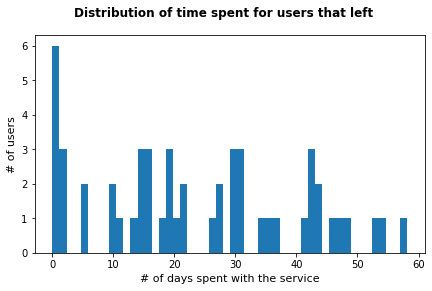

In [31]:
# Plot histogram
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that left', fontsize=12, fontweight='bold')

plt.hist(delta_time_cancelled, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [33]:
# Look at the statistics
print('Statistics for time spent with the service for users that cancelled:')
spark.createDataFrame(delta_time_cancelled, FloatType()).describe().show()

Statistics for time spent with the service for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|                52|
|   mean|23.514647929356077|
| stddev|16.684212433229213|
|    min|       0.020532407|
|    max|         58.177155|
+-------+------------------+



In [34]:
# Check how much time (in days) was spent by the users that stayed
delta_time_staying = []
for i in range(len(users_staying_list)):
    user_timestamps = user_log_stayed.select(["ts"]).where(user_log_stayed.userId == users_staying_list[i]).collect()
    delta_time_staying.append((user_timestamps[-1][0]/1000 - user_timestamps[0][0]/1000)/(3600*24))

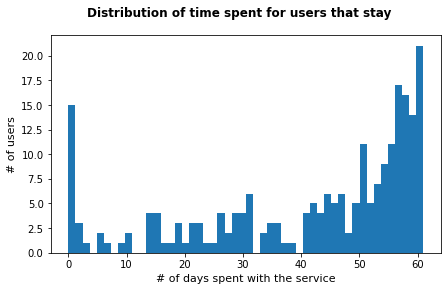

In [35]:
# Plot histogram
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that stay', fontsize=12, fontweight='bold')

plt.hist(delta_time_staying, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [36]:
# Look at the statistics
print('Statistics for time spent with the service for users that stayed:')
spark.createDataFrame(delta_time_staying, FloatType()).describe().show()

Statistics for time spent with the service for users that stayed:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|               225|
|   mean|41.565256722782635|
| stddev| 19.01386569565174|
|    min|      0.0048611113|
|    max|          60.99772|
+-------+------------------+



What about the # of songs they have listened?

In [50]:
user_canc_0_songs = user_log_valid.select(["userId", "song"]).\
    where((user_log_valid.userId == users_cancelled[0][0]) & (user_log_valid.song != "")).\
    dropDuplicates().collect()

In [52]:
len(user_canc_0_songs)

(8, 0.02053240740740741)

In [45]:
user_stay_0_songs = user_log_valid.select(["userId", "song"]).\
    where((user_log_valid.userId == users_staying[0][0]) & (user_log_valid.song != "")).\
    dropDuplicates().collect()

In [53]:
len(user_stay_0_songs)

269

We can collect this info all for the users:

In [59]:
# Check how many songs were listened by the users that left
songs_cancelled = []
for i in range(len(users_cancelled_list)):
    user_songs = user_log_cancelled.select(["userId", "song"]).\
    where((user_log_cancelled.userId == users_cancelled_list[i]) & (user_log_cancelled.song != "")).\
    dropDuplicates().collect()
    songs_cancelled.append(len(user_songs))

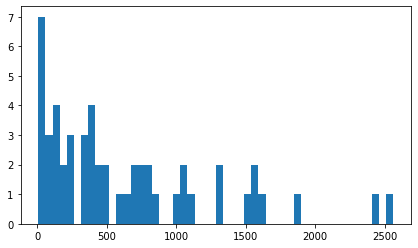

In [66]:
fig = plt.figure(figsize=(7, 4))
plt.hist(songs_cancelled, bins=50);

In [61]:
# Check how many songs were listened by the users that stay
songs_staying = []
for i in range(len(users_staying_list)):
    user_songs = user_log_stayed.select(["userId", "song"]).\
    where((user_log_stayed.userId == users_staying_list[i]) & (user_log_stayed.song != "")).\
    dropDuplicates().collect()
    songs_staying.append(len(user_songs))

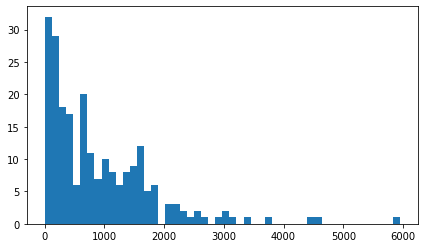

In [62]:
fig = plt.figure(figsize=(7, 4))
plt.hist(songs_staying, bins=50);

In [68]:
from operator import truediv

song_per_day_cancelled = list(map(truediv, songs_cancelled, delta_time_cancelled))
song_per_day_staying = list(map(truediv, songs_staying, delta_time_staying))

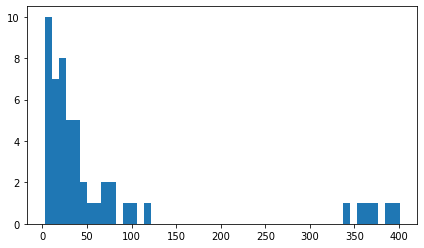

In [69]:
fig = plt.figure(figsize=(7, 4))
plt.hist(song_per_day_cancelled, bins=50);

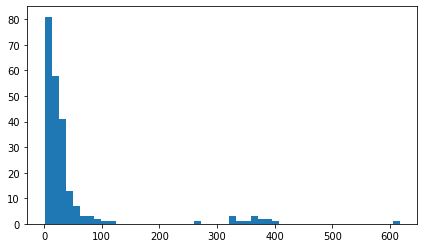

In [70]:
fig = plt.figure(figsize=(7, 4))
plt.hist(song_per_day_staying, bins=50);

In [ ]:
# window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# user_log_valid_2 = user_log_valid.withColumn("Schurn", Ssum("churn").over(window))

In [ ]:
# user_log_valid_2.head()

In [ ]:
# user_log_valid_2.tail(5)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.